### 1. Import Python module

In [1]:
# https://ai.plainenglish.io/best-performance-tuning-practices-for-pytorch-3ef06329d5fe
import gc
import time
import os
import random
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
from sklearn.metrics import *
from sklearn.model_selection import KFold

seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

num_workers = 4
batch_size = 32
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
categories = ['COVID19', 'NORMAL', 'PNEUMONIA']
num_classes = len(categories)
splits = ['train', 'test']
DATA_PATH = r"C:\Gunther\Datasets\Covid19DLH\Data"
model_path = r"C:\Gunther\OneDrive - University of Illinois - Urbana\Python\DLH\COVID-19-CHEST-X-RAY-IMAGE-CLASSISICATION"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'You are using {device}')

You are using cuda


In [2]:
torch.cuda.empty_cache()

In [ ]:
#torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(0))
print(torch.cuda.memory_reserved(0))

In [8]:
#torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(0))
print(torch.cuda.memory_reserved(0))

124315136
1969225728


### 2. Data pre-processing (Augmentation + DataLoader)

In [3]:
def show_dataset(data_path=DATA_PATH):
    df = pd.DataFrame(columns = ['code'] + splits, index = categories)
    for row in categories:
        for col in splits:
            df.loc[row,col] = int(len(os.listdir(os.path.join(data_path, col+'/'+row))))
    df['total'] = df.sum(axis=1).astype(int)
    df.loc['TOTAL'] = df.sum(axis=0).astype(int)
    df['code'] = ['0', '1', '2', '']
    print(df)
    return df

def load_data(data_path=DATA_PATH, num_workers=num_workers):
    transform_dict = {
        'model': transforms.Compose(
        [transforms.Resize(224),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         ])}
    train_data = datasets.ImageFolder(root=data_path + '/train', transform=transform_dict['model'])
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_data = datasets.ImageFolder(root=data_path + '/test', transform=transform_dict['model'])
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_data, test_data, train_loader, test_loader

train_data, test_data, train_loader, test_loader = load_data()
dataset = torch.utils.data.ConcatDataset([train_data, test_data])
df_dataset = show_dataset()

          code train  test  total
COVID19      0   460   116    576
NORMAL       1  1266   317   1583
PNEUMONIA    2  3418   855   4273
TOTAL           5144  1288   6432


### 3. Explore processed image

Sample images for training purpose:
tensor([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2,
        2, 1, 1, 2, 2, 2, 2, 2])


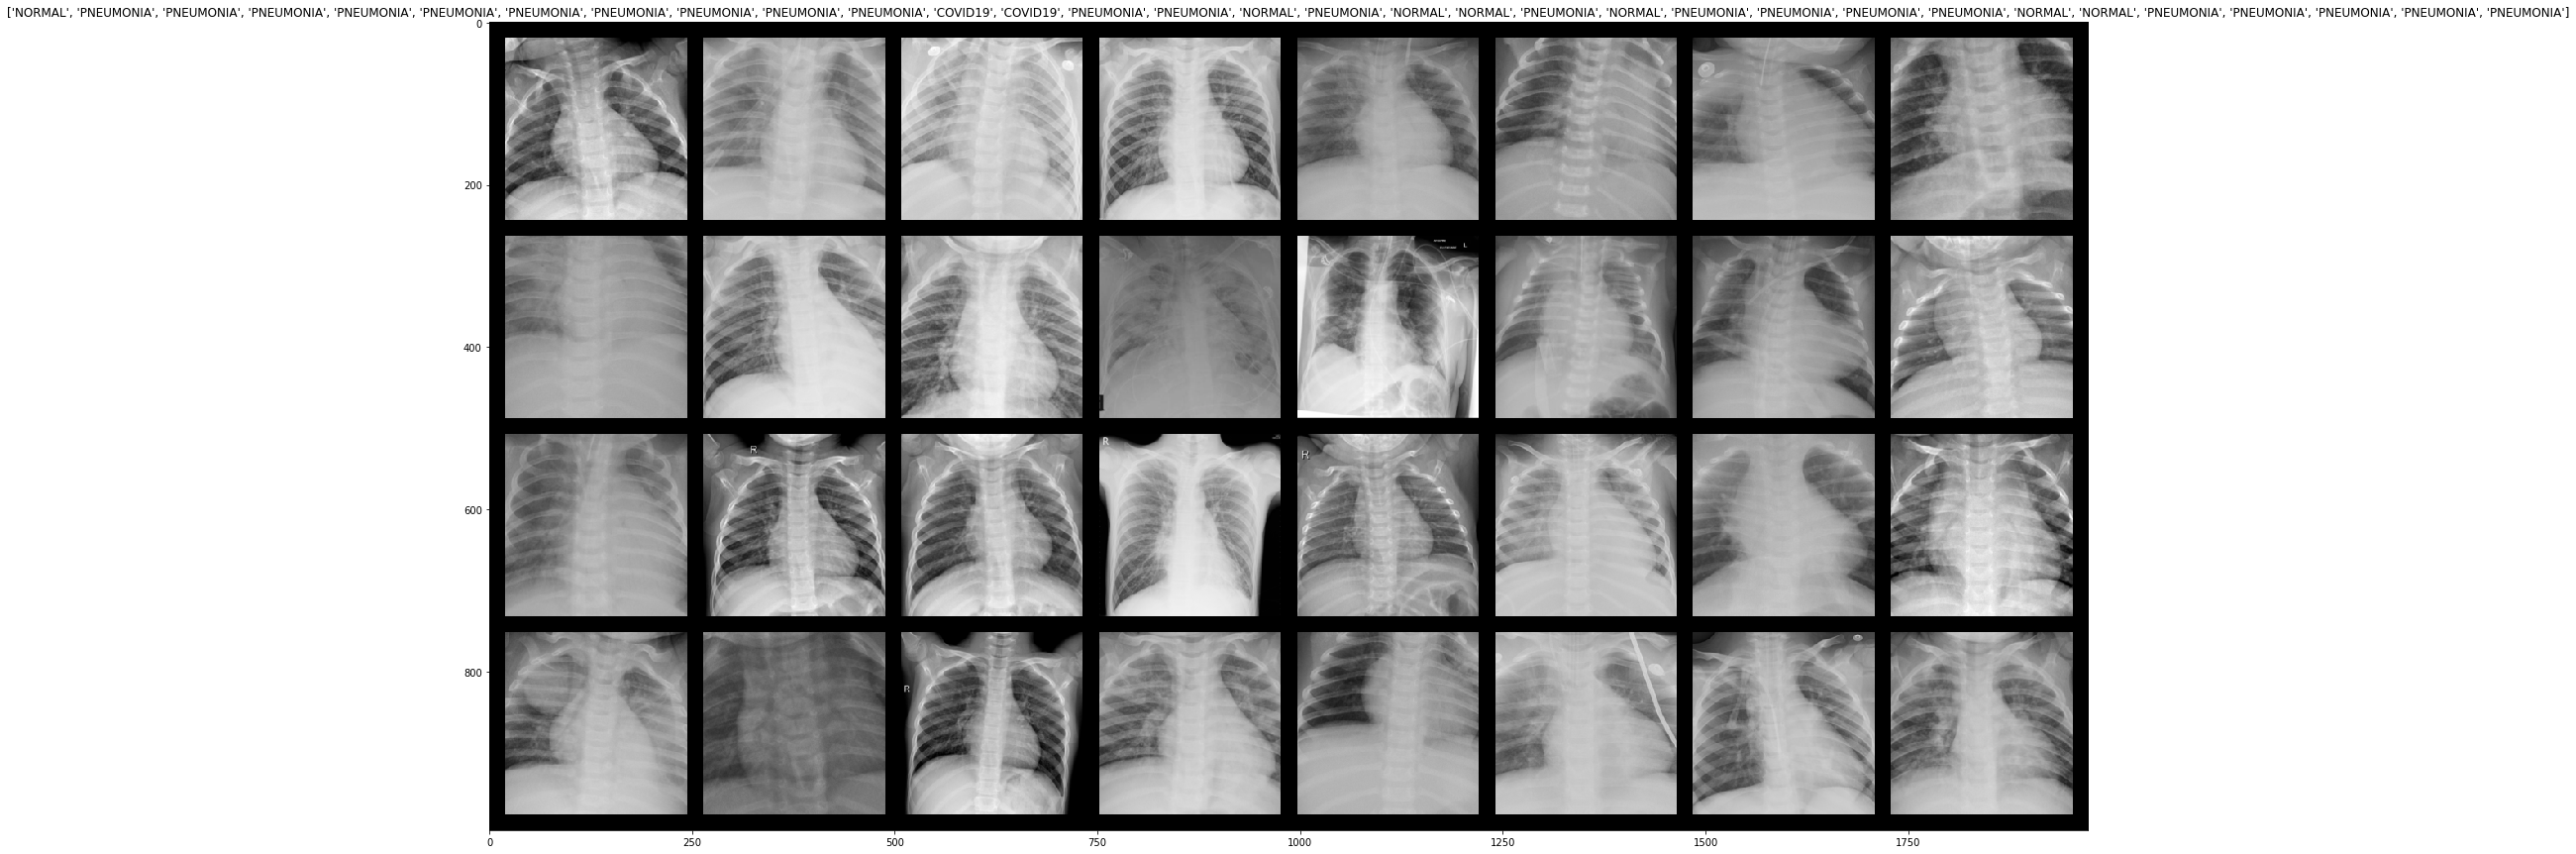

In [4]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    grid = torchvision.utils.make_grid(images, padding=20)
    print(labels)
    npgrid = grid.detach().cpu().numpy()
    plt.figure(figsize=(30, 15))
    plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
    plt.title(label=["COVID19" if x==0  else ("NORMAL" if x == 1 else "PNEUMONIA") for x in labels])
    plt.show()

print(f'Sample images for training purpose:')
for i in range(1):
    show_batch_images(train_loader)

### 3. Create the train, evaluate and test functions

In [5]:
def calc_metrics(predictions, actuals, row):
    df = pd.DataFrame(columns =metrics)
    Y_pred = np.concatenate(predictions, axis=0)
    Y_test = np.concatenate(actuals, axis=0)
    #df.loc[row, 'AUC'] = roc_auc_score(Y_test, Y_pred, multi_class='ovo')
    df.loc[row, 'Accuracy'] = accuracy_score(Y_test, Y_pred)
    df.loc[row, 'Precision'] = precision_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'Recall'] = recall_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'F1-score'] = f1_score(Y_test, Y_pred, average="macro")
    return df

def calc_pred_actual(model, loader):
    model.eval()
    torch.manual_seed(seed)
    predictions, actuals = [], []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            Y_pred_orig = model(data)
            _, Y_pred_tag = torch.max(Y_pred_orig, dim = 1)
            Y_pred_tag = Y_pred_tag.detach().cpu().numpy()
            Y_pred_tag = Y_pred_tag.reshape(len(Y_pred_tag), 1).astype('int8')
            Y_test = target.detach().cpu().numpy()
            Y_test = Y_test.reshape(len(Y_test), 1).astype('int8')
            predictions.append(Y_pred_tag)
            actuals.append(Y_test)
            gc.collect()
            torch.cuda.empty_cache()
    return predictions, actuals

def create_confusion_matrix(preds, y_test):
    ylist, predlist = [], []
    for pred in preds:
        for item in pred:
            predlist.append(int(item))
    for y in y_test:
        for item in y:
            ylist.append(int(item))
    data_dict = {'y_Actual':    ylist, 'y_Predicted': predlist}
    df = pd.DataFrame(data_dict, columns=['y_Actual','y_Predicted'])
    cm = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['ACTUAL'], colnames=['PREDICTED'])
    return cm

def train_model(model):
    model.to(device).train()
    t0 = time.time()
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'loss'])
    print(f"Training the model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and {n_epochs} epochs \n")
    for epoch in range(n_epochs):
        curr_epoch_loss = 0.0
        for i, (data, target) in enumerate(train_loader):
            target = target.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            curr_epoch_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch}:\t loss={curr_epoch_loss/(i+1):.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, curr_epoch_loss/(i+1)]
        gc.collect()
        torch.cuda.empty_cache()
    return model, df

def validate_model(model, k_folds = 5):
    model.eval()
    print(f"Validating the model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and {k_folds}-folds \n")
    df = pd.DataFrame(columns = metrics)
    kfold = KFold(n_splits=k_folds, shuffle=True)
    for fold, (train_ids, test_ids) in enumerate(kfold.split(train_data)):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=train_subsampler)
        test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=test_subsampler)
        predictions, actuals = calc_pred_actual(model, train_loader)
        conf_matrix = create_confusion_matrix(predictions, actuals)
        df_aux = calc_metrics(predictions, actuals, 'FOLD '+str(fold+1))
        df = df.append(df_aux)
    df.loc['Average'] = df.mean(axis=0)
    print(df.astype(float))
    return df.astype(float), conf_matrix

def test_model(model):
    model.eval()
    print(f"Testing the model {model_name} with {df_dataset.loc['TOTAL', 'test']} samples \n")
    predictions, actuals = calc_pred_actual(model, test_loader)
    conf_matrix = create_confusion_matrix(predictions, actuals)
    df_test = calc_metrics(predictions, actuals, 'Test Results').astype(float)
    print(df_test)
    return df_test, conf_matrix

def plot_epoch(df):
    _ = plt.plot(df['epoch'], df['loss'])
    plt.xlabel('Epoch') 
    plt.ylabel('Loss')
    _ = plt.title(label=f"Training loss vs epoch for model: {df.iloc[0,0]}", fontsize=15, color="darkblue")
    plt.show()

### 4. Build our own model

#### 4.1 Architecture of our own model

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 128, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv2 = nn.Conv2d(128, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear1 = nn.Linear(28 * 28 * 32, 512)
        self.dropout = nn.Dropout()
        self.linear2 = nn.Linear(512, 3)
    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

#### 4.2 Define parameters of our own model

In [13]:
net = Net().to(device)
model_name = 'DLH_team'
n_epochs = 25
learning_rate = 1e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

#### 4.3 Train our own model and save

In [14]:
our_model, df_epochs = train_model(net)

Training the model DLH_team with 5144 samples and 25 epochs 

Epoch 0:	 loss=0.39547 	 time=44.76s
Epoch 1:	 loss=0.22756 	 time=97.11s
Epoch 2:	 loss=0.18364 	 time=152.26s
Epoch 3:	 loss=0.16234 	 time=213.49s
Epoch 4:	 loss=0.14894 	 time=291.63s
Epoch 5:	 loss=0.13101 	 time=394.19s
Epoch 6:	 loss=0.11934 	 time=518.71s
Epoch 7:	 loss=0.10620 	 time=685.64s
Epoch 8:	 loss=0.10205 	 time=804.40s
Epoch 9:	 loss=0.08981 	 time=955.82s
Epoch 10:	 loss=0.08723 	 time=1057.19s
Epoch 11:	 loss=0.08561 	 time=1203.75s
Epoch 12:	 loss=0.07521 	 time=1322.44s
Epoch 13:	 loss=0.06811 	 time=1449.95s
Epoch 14:	 loss=0.05918 	 time=1584.95s
Epoch 15:	 loss=0.05462 	 time=1690.84s
Epoch 16:	 loss=0.04980 	 time=1832.28s
Epoch 17:	 loss=0.05301 	 time=1959.29s
Epoch 18:	 loss=0.03867 	 time=2076.52s
Epoch 19:	 loss=0.04074 	 time=2426.66s
Epoch 20:	 loss=0.03855 	 time=2556.48s
Epoch 21:	 loss=0.02459 	 time=2683.43s
Epoch 22:	 loss=0.03267 	 time=2823.99s
Epoch 23:	 loss=0.02470 	 time=2933.29s


In [15]:
test_results, conf_matrix_test = test_model(our_model)

Testing the model DLH_team with 1288 samples 

              Accuracy  Precision    Recall  F1-score
Test Results   0.96118   0.955759  0.956178  0.955878


In [21]:
torch.save(our_model.state_dict(), os.path.join(model_path, 'model.pth'))

#### 4.4 Plot epoch loss of our own model

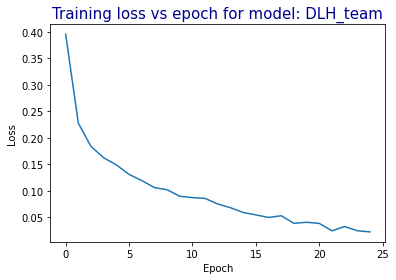

In [22]:
plot_epoch(df_epochs)

#### 4.5 Validate our own model

In [19]:
validation_results, conf_matrix_val = validate_model(our_model, k_folds = 5)

Validating the model DLH_team with 5144 samples and 5-folds 

         Accuracy  Precision    Recall  F1-score
FOLD 1   0.998785   0.999396  0.997741  0.998566
FOLD 2   0.998785   0.999389  0.997800  0.998592
FOLD 3   0.998785   0.999393  0.998355  0.998872
FOLD 4   0.999028   0.999511  0.998135  0.998822
FOLD 5   0.998785   0.999390  0.997782  0.998584
Average  0.998834   0.999416  0.997963  0.998687


#### 4.6 Show confusion matrix of our own model for validation dataset

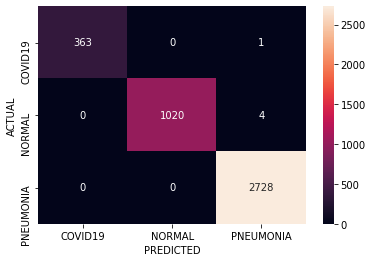

In [20]:
_ = sn.heatmap(conf_matrix_val, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

#### 4.7 Test our own model

In [16]:
test_results, conf_matrix_test = test_model(our_model)

Testing the model DLH_team with 1288 samples 

              Accuracy  Precision    Recall  F1-score
Test Results   0.96118   0.955759  0.956178  0.955878


#### 4.8 Show confusion matrix for test dataset

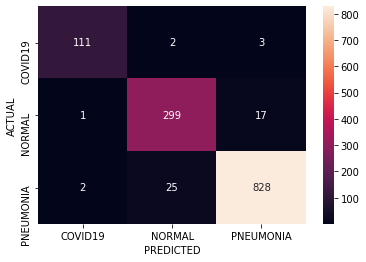

In [17]:
_ = sn.heatmap(conf_matrix_test, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

#### 4.9 (Optional) load a model already saved

In [6]:
model_name = 'DLH_team'
our_model = Net().to(device)  
our_model.load_state_dict(torch.load(os.path.join(model_path, 'model.pth')))  
_ = our_model.eval()

### 5. Create a model from a pre-trained one

#### 5.1 Select the pre-trained model

In [14]:
n_epochs = 20
learning_rate = 1e-2
model_name = 'Resnet18'
pre_trained_model = torchvision.models.resnet18(pretrained=True)

for param in pre_trained_model.parameters():
    param.requires_grad = False
num_ftrs = pre_trained_model.fc.in_features        
pre_trained_model.fc = nn.Linear(num_ftrs, num_classes)
pre_trained_model = pre_trained_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(pre_trained_model.fc.parameters(), lr= learning_rate)

#### 5.2 Train the pre-trained model and save

In [ ]:
new_model, df_epochs2 = train_model(pre_trained_model.to(device))
torch.save(new_model.state_dict(), os.path.join(model_path, 'pretrained.pth'))

#### 5.3 Plot epoch loss of the pre-trained model

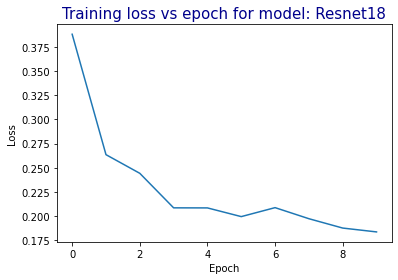

In [26]:
plot_epoch(df_epochs2)

#### 5.3 Validate the pre-trained model

In [27]:
validation_results, conf_matrix_val2 = validate_model(new_model, k_folds = 5)

Validating the model Resnet18 with 5144 samples and 5-folds 

              AUC  Precision    Recall  F1-score
FOLD 1   0.954313   0.957975  0.939580  0.948415
FOLD 2   0.949696   0.953246  0.933266  0.942668
FOLD 3   0.947509   0.951948  0.930121  0.940247
FOLD 4   0.949696   0.954990  0.935117  0.944357
FOLD 5   0.950923   0.956980  0.933190  0.944293
Average  0.950428   0.955028  0.934255  0.943996


#### 5.4 Show confusion matrix of the pre-trained model for validation dataset

In [ ]:
_ = sn.heatmap(conf_matrix_test2, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

#### 5.5 Test the pre-trained model and save

In [28]:
test_results, conf_matrix_val2 = test_model(new_model)

Testing the model Resnet18 with 1288 samples 

                  AUC  Precision    Recall  F1-score
Test Results  0.93323   0.944319  0.883379  0.910834


#### 5.6 Show confusion matrix of the pre-trained model for test dataset

In [ ]:
test_results, conf_matrix_test2 = test_model(new_model)

In [ ]:
def test_model(model):
    model.eval()
    print(f"Testing the model {model_name} with {df_dataset.loc['TOTAL', 'test']} samples \n")
    predictions, actuals = calc_pred_actual(model, test_loader)
    conf_matrix = create_confusion_matrix(predictions, actuals)
    df_test = calc_metrics(predictions, actuals, 'Test Results').astype(float)
    print(df_test)
    return df_test, conf_matrix

In [21]:
import gc
model = our_model
model.eval()
print(f"Testing the model {model_name} with {df_dataset.loc['TOTAL', 'test']} samples \n")
torch.manual_seed(seed)
predictions, actuals = [], []
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)
        Y_pred_orig = model(data)
        _, Y_pred_tag = torch.max(Y_pred_orig, dim = 1)
        Y_pred_tag = Y_pred_tag.cpu().numpy()
        Y_pred_tag = Y_pred_tag.reshape(len(Y_pred_tag), 1).astype('int8')
        Y_test = target.cpu().numpy()
        Y_test = Y_test.reshape(len(Y_test), 1).astype('int8')
        if i==1: 
            print(i,  Y_pred_tag)
            print('actuals')
        if i==1: print(i, Y_test)
        predictions.append(Y_pred_tag)
        actuals.append(Y_test)
        gc.collect()
        torch.cuda.empty_cache()
    df_test = calc_metrics(predictions, actuals, 'Test Results').astype(float)
df_test

Testing the model DLH_team with 1288 samples 

1 [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [2]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
actuals
1 [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


,Accuracy,Precision,Recall,F1-score
Test Results,0.934783,0.95598,0.899905,0.923804


In [21]:
print(torch.cuda.memory_allocated(0))
print(torch.cuda.memory_reserved(0))

2783331328
2906652672
